In [1]:
import os
os.environ['KAGGLE_USERNAME'] = ''  # Your Kaggle username
os.environ['KAGGLE_KEY'] = ''  # Your Kaggle API key
os.environ['URN'] = '6644818'  # Your URN: submissions without a URN will not count

#!kaggle competitions download -c uos-com2028-21-22-cw
#!unzip uos-com2028-21-22-cw.zip

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, utils
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.data import AUTOTUNE

import random
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

2022-05-07 13:24:19.547259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 13:24:19.573129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 13:24:19.573336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Read the data

In [3]:
color_mode = 'grayscale'
image_size = (28, 28)
image_shape = (*image_size, 1)
batch_size = 1000

num_classes = 8

In [4]:
#read all labels
train_labels_dp = pd.read_csv('train.csv')
train_labels = tf.constant(train_labels_dp.loc[:, 'Cell type'].values)

2022-05-07 13:24:19.646179: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-07 13:24:19.646677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 13:24:19.647155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 13:24:19.647281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
#based on https://www.tensorflow.org/tutorials/load_data/images

def pathToLabel(path):
  path = tf.strings.regex_replace(path, "./train/", "")
  path = tf.strings.regex_replace(path, ".jpg", "")
  return train_labels[tf.strings.to_number(path, out_type=tf.int32)]

def decode_image(img):
  # channels were reduced to 1 since image is grayscale
  img = tf.io.decode_jpeg(img, channels=1)

  return tf.image.resize(img, image_size)

def process_path(path, addPath=False):
  label = pathToLabel(path)

  print (label)

  img = tf.io.read_file(path)
  img = decode_image(img)

  if addPath:
    return img, label, path
  else:
    return img, label

def configure_for_performance(ds: tf.data.Dataset) -> tf.data.Dataset:
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size= 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(AUTOTUNE)
  return ds

def prepare_dataset(ds: tf.data.Dataset) -> tf.data.Dataset:
  ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
  ds = configure_for_performance(ds)
  return ds
  

In [6]:
# https://www.tensorflow.org/tutorials/keras/regression
def plot_loss(history, val=True, color="b", save=False):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['accuracy'], label='accuracy')
  if val:
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('error')
  plt.legend()
  plt.grid(True)
  if save:
    plt.savefig('./fig.png')
  else:
    plt.show()

In [7]:
seed = random.randint(0, 10000)

print("seed: %d" % seed)

# Read all the files from the direcotry
list_ds = tf.data.Dataset.list_files(str('./train/*'), shuffle=False)

image_count = len(list_ds)

list_ds = list_ds.shuffle(image_count, seed=seed)

val_size = int(image_count * 0.1)

train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

train_ds = prepare_dataset(train_ds)
val_ds   = prepare_dataset(val_ds)


seed: 6348
Tensor("strided_slice:0", shape=(), dtype=int64)
Tensor("strided_slice:0", shape=(), dtype=int64)


In [2]:
# Show some images
# image_batch, label_batch  = next(iter(train_ds))

# plt.figure(figsize=image_size)
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')

#   label = label_batch[i]
#   path = ""#str(path_batch[i].numpy())

#   plt.title(str(label.numpy()) + " " + path)
#   plt.axis("off")


Read the testing set

In [13]:
test_ds = image_dataset_from_directory(
  './test', 
  labels=None, 
  shuffle=False,
  color_mode=color_mode,
  batch_size=batch_size,
  image_size=image_size)

Found 50000 files belonging to 1 classes.


Create a model

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_54 (Sequential)  (None, 28, 28, 1)         0         
                                                                 
 rescaling_27 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 conv2d_81 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_81 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_108 (Dropout)       (None, 14, 14, 32)      

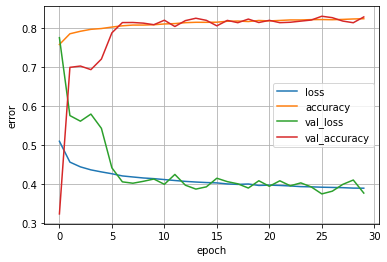

training model  1 140296472811920
Epoch 1/30
135/135 [==============================] - 6s 36ms/step - loss: 0.2094 - accuracy: 0.9470 - val_loss: 0.1935 - val_accuracy: 0.9555
Epoch 2/30
135/135 [==============================] - 5s 36ms/step - loss: 0.1820 - accuracy: 0.9528 - val_loss: 0.2489 - val_accuracy: 0.9503
Epoch 3/30
135/135 [==============================] - 5s 35ms/step - loss: 0.1790 - accuracy: 0.9529 - val_loss: 0.3060 - val_accuracy: 0.9481
Epoch 4/30
135/135 [==============================] - 5s 35ms/step - loss: 0.1767 - accuracy: 0.9527 - val_loss: 0.3282 - val_accuracy: 0.9529
Epoch 5/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1745 - accuracy: 0.9531 - val_loss: 0.2383 - val_accuracy: 0.9500
Epoch 6/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1736 - accuracy: 0.9527 - val_loss: 0.2092 - val_accuracy: 0.9559
Epoch 7/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1731 - accuracy: 0.9523 - val_l

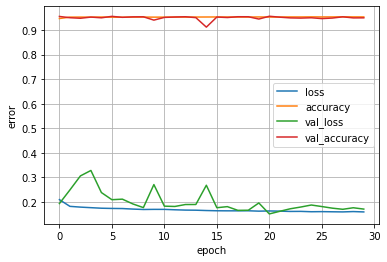

training model  2 140296987651872
Epoch 1/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1524 - accuracy: 0.9585 - val_loss: 0.3634 - val_accuracy: 0.9657
Epoch 2/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1185 - accuracy: 0.9638 - val_loss: 0.4654 - val_accuracy: 0.9653
Epoch 3/30
135/135 [==============================] - 5s 35ms/step - loss: 0.1109 - accuracy: 0.9645 - val_loss: 0.5826 - val_accuracy: 0.9669
Epoch 4/30
135/135 [==============================] - 5s 33ms/step - loss: 0.1081 - accuracy: 0.9644 - val_loss: 0.4753 - val_accuracy: 0.9639
Epoch 5/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1049 - accuracy: 0.9643 - val_loss: 0.2100 - val_accuracy: 0.9656
Epoch 6/30
135/135 [==============================] - 5s 37ms/step - loss: 0.1029 - accuracy: 0.9641 - val_loss: 0.1552 - val_accuracy: 0.9645
Epoch 7/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1010 - accuracy: 0.9644 - val_l

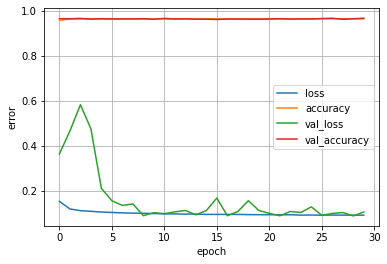

training model  3 140296465087360
Epoch 1/30
135/135 [==============================] - 5s 34ms/step - loss: 0.2650 - accuracy: 0.9029 - val_loss: 0.3173 - val_accuracy: 0.9069
Epoch 2/30
135/135 [==============================] - 5s 33ms/step - loss: 0.2095 - accuracy: 0.9173 - val_loss: 0.3005 - val_accuracy: 0.9009
Epoch 3/30
135/135 [==============================] - 5s 33ms/step - loss: 0.2006 - accuracy: 0.9196 - val_loss: 0.2534 - val_accuracy: 0.9085
Epoch 4/30
135/135 [==============================] - 5s 33ms/step - loss: 0.1953 - accuracy: 0.9212 - val_loss: 0.2228 - val_accuracy: 0.9006
Epoch 5/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1907 - accuracy: 0.9225 - val_loss: 0.1864 - val_accuracy: 0.9248
Epoch 6/30
135/135 [==============================] - 5s 33ms/step - loss: 0.1877 - accuracy: 0.9232 - val_loss: 0.1854 - val_accuracy: 0.9229
Epoch 7/30
135/135 [==============================] - 5s 33ms/step - loss: 0.1854 - accuracy: 0.9241 - val_l

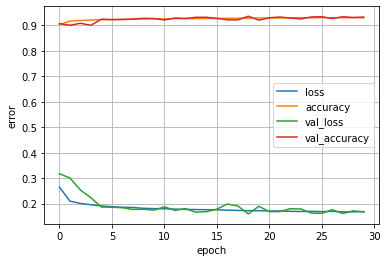

training model  4 140296465076128
Epoch 1/30
135/135 [==============================] - 6s 37ms/step - loss: 0.2322 - accuracy: 0.9220 - val_loss: 0.2610 - val_accuracy: 0.9315
Epoch 2/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1893 - accuracy: 0.9288 - val_loss: 1.0785 - val_accuracy: 0.3075
Epoch 3/30
135/135 [==============================] - 5s 35ms/step - loss: 0.1836 - accuracy: 0.9309 - val_loss: 1.8467 - val_accuracy: 0.2127
Epoch 4/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1777 - accuracy: 0.9326 - val_loss: 0.3651 - val_accuracy: 0.8164
Epoch 5/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1744 - accuracy: 0.9331 - val_loss: 0.2057 - val_accuracy: 0.9079
Epoch 6/30
135/135 [==============================] - 5s 35ms/step - loss: 0.1733 - accuracy: 0.9336 - val_loss: 0.1768 - val_accuracy: 0.9266
Epoch 7/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1704 - accuracy: 0.9344 - val_l

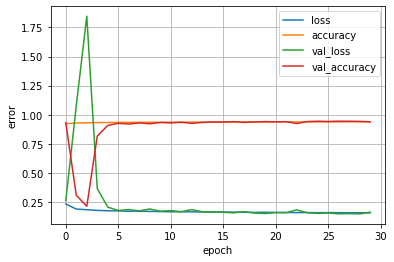

training model  5 140296473381232
Epoch 1/30
135/135 [==============================] - 6s 35ms/step - loss: 0.1804 - accuracy: 0.9484 - val_loss: 0.5655 - val_accuracy: 0.9536
Epoch 2/30
135/135 [==============================] - 5s 33ms/step - loss: 0.1451 - accuracy: 0.9524 - val_loss: 0.9506 - val_accuracy: 0.9533
Epoch 3/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1386 - accuracy: 0.9534 - val_loss: 1.0228 - val_accuracy: 0.9533
Epoch 4/30
135/135 [==============================] - 5s 35ms/step - loss: 0.1349 - accuracy: 0.9532 - val_loss: 0.8044 - val_accuracy: 0.9562
Epoch 5/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1321 - accuracy: 0.9539 - val_loss: 0.3693 - val_accuracy: 0.9555
Epoch 6/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1291 - accuracy: 0.9539 - val_loss: 0.1422 - val_accuracy: 0.9536
Epoch 7/30
135/135 [==============================] - 5s 34ms/step - loss: 0.1289 - accuracy: 0.9540 - val_l

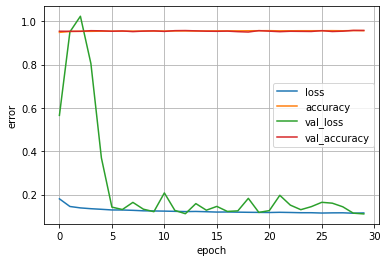

training model  6 140300414041200
Epoch 1/30
135/135 [==============================] - 6s 35ms/step - loss: 0.4581 - accuracy: 0.8098 - val_loss: 0.5555 - val_accuracy: 0.7679
Epoch 2/30
135/135 [==============================] - 5s 35ms/step - loss: 0.4019 - accuracy: 0.8303 - val_loss: 0.6192 - val_accuracy: 0.7632
Epoch 3/30
135/135 [==============================] - 5s 38ms/step - loss: 0.3924 - accuracy: 0.8344 - val_loss: 0.6261 - val_accuracy: 0.6498
Epoch 4/30
135/135 [==============================] - 5s 36ms/step - loss: 0.3860 - accuracy: 0.8364 - val_loss: 0.4578 - val_accuracy: 0.7901
Epoch 5/30
135/135 [==============================] - 5s 34ms/step - loss: 0.3824 - accuracy: 0.8382 - val_loss: 0.4429 - val_accuracy: 0.8218
Epoch 6/30
135/135 [==============================] - 5s 33ms/step - loss: 0.3778 - accuracy: 0.8399 - val_loss: 0.4118 - val_accuracy: 0.8307
Epoch 7/30
135/135 [==============================] - 5s 33ms/step - loss: 0.3744 - accuracy: 0.8411 - val_l

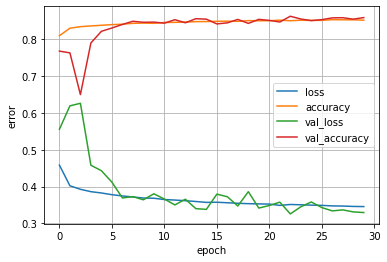

training model  7 140296467607376
Epoch 1/30
135/135 [==============================] - 6s 35ms/step - loss: 0.4485 - accuracy: 0.8404 - val_loss: 0.5495 - val_accuracy: 0.8529
Epoch 2/30
135/135 [==============================] - 5s 36ms/step - loss: 0.3831 - accuracy: 0.8519 - val_loss: 0.7623 - val_accuracy: 0.8512
Epoch 3/30
135/135 [==============================] - 5s 36ms/step - loss: 0.3730 - accuracy: 0.8536 - val_loss: 0.8621 - val_accuracy: 0.8497
Epoch 4/30
135/135 [==============================] - 5s 35ms/step - loss: 0.3660 - accuracy: 0.8551 - val_loss: 0.5289 - val_accuracy: 0.8513
Epoch 5/30
135/135 [==============================] - 5s 34ms/step - loss: 0.3603 - accuracy: 0.8569 - val_loss: 0.4051 - val_accuracy: 0.8485
Epoch 6/30
135/135 [==============================] - 5s 36ms/step - loss: 0.3567 - accuracy: 0.8577 - val_loss: 0.3757 - val_accuracy: 0.8552
Epoch 7/30
135/135 [==============================] - 5s 37ms/step - loss: 0.3525 - accuracy: 0.8584 - val_l

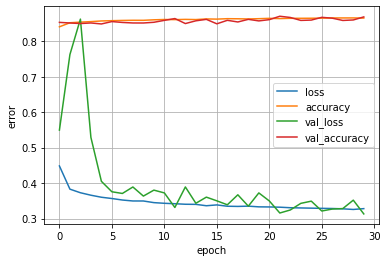

In [11]:
def create_model():
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal_and_vertical",
                          input_shape=image_shape),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.1),
      ]
    )

    model = keras.Sequential()

    model.add(data_augmentation)

    model.add(layers.Rescaling(1.0/255, input_shape=image_shape))
    model.add(layers.Conv2D(32, 3, activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    return model

model1 = create_model()
model1.summary()


def create_multi_model_sets(train_ds, val_ds):
    model_ds = []

    for i in range(num_classes):
        model_ds.append(
          (
            create_model(),
            train_ds.map(lambda x, y: (x, tf.cast(y==i, tf.int8))),
            val_ds.map(lambda x, y: (x, tf.cast(y==i, tf.int8)))
          ))

    return model_ds


models: (tf.keras.Model, tf.data.Dataset, tf.data.Dataset) = create_multi_model_sets(train_ds, val_ds)

for i, (model, train, val) in enumerate(models):
     print("training model ", i, id(model))
     hist = model.fit(train, validation_data=val, epochs=30)
     plot_loss(hist)

In [14]:
ps = []

for (model, _, _) in models:
  p = model.predict(test_ds).flatten()
  ps.append(p)

psf = []

for i in range(len(ps[0])):
  psf.append(np.argmax([p[i] for p in ps]))

psf[:10]

[6,
 6,
 4,
 0,
 5,
 7,
 1,
 0,
 0,
 0,
 6,
 1,
 3,
 4,
 3,
 6,
 0,
 6,
 6,
 6,
 3,
 0,
 7,
 0,
 4,
 3,
 4,
 3,
 1,
 4,
 0,
 0,
 6,
 6,
 0,
 6,
 0,
 0,
 6,
 6,
 4,
 7,
 6,
 3,
 7,
 0,
 0,
 6,
 0,
 0,
 5,
 6,
 1,
 4,
 6,
 0,
 6,
 6,
 0,
 7,
 6,
 3,
 6,
 6,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 0,
 7,
 6,
 0,
 3,
 3,
 0,
 6,
 0,
 6,
 3,
 6,
 7,
 5,
 4,
 0,
 6,
 3,
 1,
 0,
 6,
 6,
 6,
 0,
 0,
 4,
 2,
 0,
 7,
 0,
 6,
 7,
 6,
 1,
 6,
 6,
 0,
 0,
 7,
 0,
 0,
 7,
 3,
 4,
 3,
 0,
 3,
 4,
 0,
 0,
 7,
 7,
 0,
 4,
 6,
 6,
 4,
 0,
 3,
 7,
 1,
 0,
 3,
 6,
 3,
 6,
 7,
 6,
 6,
 0,
 0,
 0,
 0,
 3,
 4,
 6,
 3,
 7,
 0,
 6,
 0,
 0,
 0,
 5,
 0,
 0,
 7,
 3,
 6,
 0,
 0,
 6,
 0,
 3,
 0,
 6,
 0,
 3,
 1,
 0,
 4,
 0,
 6,
 0,
 0,
 4,
 0,
 0,
 6,
 3,
 3,
 3,
 6,
 1,
 0,
 7,
 0,
 5,
 7,
 6,
 7,
 6,
 3,
 3,
 7,
 3,
 5,
 5,
 0,
 7,
 7,
 0,
 4,
 0,
 0,
 0,
 0,
 6,
 0,
 3,
 0,
 7,
 7,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 7,
 6,
 3,
 0,
 3,
 3,
 7,
 6,
 6,
 0,
 7,
 0,
 0,
 7,
 6,
 3,
 0,
 0,
 1,
 0,
 4,
 6,
 3,
 0,
 6,


In [15]:
from pandas import DataFrame
DataFrame(data={'Cell type': psf}).to_csv('predictions.csv', index_label='Id')

In [16]:
!kaggle competitions submit -m $URN -c uos-com2028-21-22-cw -f predictions.csv

100%|█████████████████████████████████████████| 380k/380k [00:02<00:00, 189kB/s]
Successfully submitted to COM2028 21/22 CW